<a href="https://colab.research.google.com/github/jingkloos/Machine-learning/blob/master/Movie_Recommendation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this project, I used Item-based collaborative filtering method to recommend movies. 

I trained a KNN model using movielens dataset to cluster similar movies based on users' ratings. 

I also created APIs to recommend movies to users bases on their favorate movie input.



## Add necessary packages

In [ ]:
!pip install tmdbsimple

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Data

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip

--2020-07-30 14:15:27--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  58.7MB/s    in 4.8s    

2020-07-30 14:15:32 (54.7 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]



In [ ]:
!unzip ml-latest.zip

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [ ]:
!ls ml-latest/

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [ ]:
DATA_PATH='./ml-latest'
ratings_df = pd.read_csv(DATA_PATH+'/ratings.csv')
movies_df=pd.read_csv(DATA_PATH+'/movies.csv')
links_df=pd.read_csv(DATA_PATH+'/links.csv')
tags_df=pd.read_csv(DATA_PATH+'/tags.csv')



In [ ]:
print(ratings_df.info())
ratings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB
None


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [ ]:
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print(links_df.info())
links_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int64  
 1   imdbId   58098 non-null  int64  
 2   tmdbId   57917 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.3 MB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
print(tags_df.info())
tags_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.8+ MB
None


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


## Explore Data

Questions to answer:
1. How many movies were rated by users?
2. How many users rated the movies?
3. What is the popular ratings from users?





In [ ]:
dfs={'movies':movies_df,'ratings':ratings_df,'links':links_df,'tags':tags_df}
for i in dfs:
  print('count of {}: {}'.format(i,dfs[i].shape[0]))
num_users=len(ratings_df.userId.unique() )
num_movies=len(ratings_df.movieId.unique())
num_movies_without_rating=len(movies_df.movieId.unique())-len(ratings_df.movieId.unique())
print('There are {} unique users and {} unique movies in ratings {} movies without ratings'.format(num_users,num_movies,num_movies_without_rating))

count of movies: 58098
count of ratings: 27753444
count of links: 58098
count of tags: 1108997
There are 283228 unique users and 53889 unique movies in ratings 4209 movies without ratings


### Ratings

In [ ]:
movie_rating_ct_df=pd.DataFrame(ratings_df.groupby('movieId').size(),columns=['count'])

In [ ]:
movie_rating_ct=movie_rating_ct_df.sort_values(by='count',ascending=False,ignore_index=True)

In [ ]:
movie_rating_ct['count'].quantile(np.arange(1,0.5,-0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
0.60       12.0
0.55        9.0
Name: count, dtype: float64

Only 20% movies got 100 or more ratings. Most of the movies don't get a lot of ratings. I will limit the movies to these 20% popular movies to avoid memory issues and import KNN performance.

In [ ]:
popular_movies=list(set(movie_rating_ct_df[movie_rating_ct_df['count']>=500].index))
ratings_df_drop_movies=ratings_df[ratings_df.movieId.isin(popular_movies)]
print('Original rating count is {}'.format(ratings_df.shape[0]))
print('Popular movies rating count is {}'.format(ratings_df_drop_movies.shape[0]))

Original rating count is 27753444
Popular movies rating count is 26053205


Text(0, 0.5, 'Number of ratings (log)')

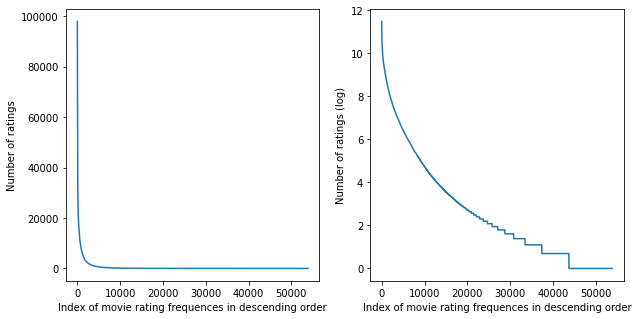

In [ ]:
#distribution
fig=plt.figure(figsize=[10,5])
fig.subplots_adjust(hspace=5)
ax1=fig.add_subplot(121)
ax1.plot(movie_rating_ct['count'])
ax1.set_xlabel('Index of movie rating frequences in descending order')
ax1.set_ylabel('Number of ratings')
ax2=fig.add_subplot(122)
ax2.plot(np.log(movie_rating_ct['count']))
ax2.set_xlabel('Index of movie rating frequences in descending order')
ax2.set_ylabel('Number of ratings (log)')
# this is a typical long tail distribution, only a few movies receive a lot of ratings

In [ ]:
user_rating_ct_df=pd.DataFrame(ratings_df.groupby('userId').size(),columns=['count'])
user_rating_ct=user_rating_ct_df.sort_values(by='count',ascending=False,ignore_index=True)

In [ ]:
user_rating_ct['count'].quantile(np.arange(1,0.5,-0.05))

1.00    23715.0
0.95      405.0
0.90      240.0
0.85      165.0
0.80      122.0
0.75       95.0
0.70       73.0
0.65       58.0
0.60       47.0
0.55       38.0
Name: count, dtype: float64

The distribution of ratings by user is very similar to the ratings by movie. Less than half of the users are very actively rating movies. I will limit users to those 20% active users

In [ ]:
active_users=list(set(user_rating_ct_df[user_rating_ct_df['count']>=500].index))
ratings_df_drop_users=ratings_df_drop_movies[ratings_df_drop_movies.userId.isin(active_users)]
print('Original rating count is {}'.format(ratings_df.shape[0]))
print('Rating count of popular movies and active users is {}'.format(ratings_df_drop_users.shape[0]))

Original rating count is 27753444
Rating count of popular movies and active users is 8239836


Text(0, 0.5, 'Number of ratings (log)')

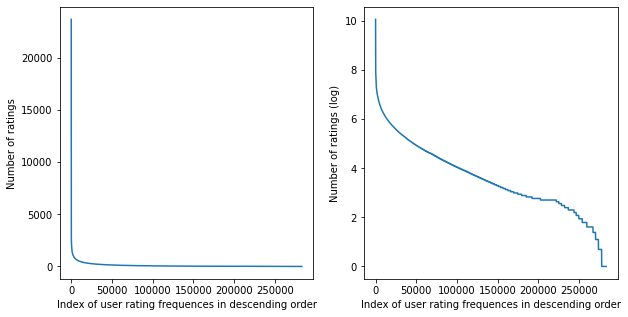

In [ ]:
#distribution
fig=plt.figure(figsize=[10,5])
fig.subplots_adjust(hspace=5)
ax1=fig.add_subplot(121)
ax1.plot(user_rating_ct['count'])
ax1.set_xlabel('Index of user rating frequences in descending order')
ax1.set_ylabel('Number of ratings')
ax2=fig.add_subplot(122)
ax2.plot(np.log(user_rating_ct['count']))
ax2.set_xlabel('Index of user rating frequences in descending order')
ax2.set_ylabel('Number of ratings (log)')
# this is a typical long tail distribution, only a few users give a lot of ratings

### Links

In [ ]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
#join movies with links to get tmdbid
movies=movies_df.merge(links_df,on='movieId',how='inner')
movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


**Get movies poster from TMDb API**

Successfully imported tmdbsimple!


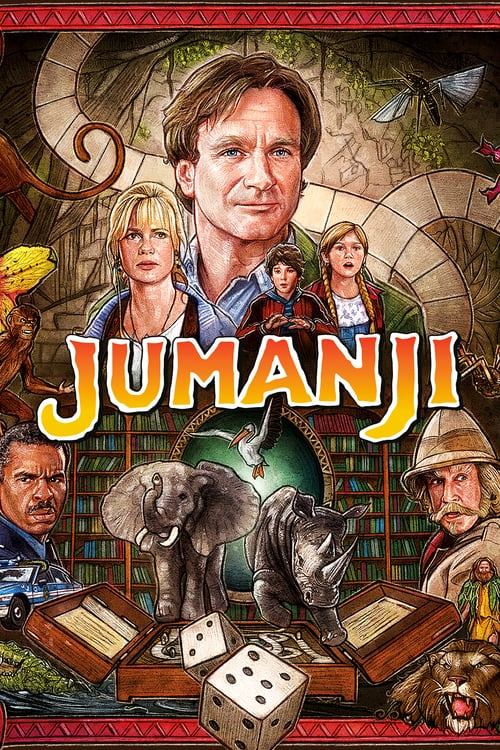

In [ ]:
from IPython.display import Image, HTML, display
import tmdbsimple as tmdb

try:
  tmdb.API_KEY='fe2a68da23a562328f579ae29586f111'
  print('Successfully imported tmdbsimple!')
  IMAGE_URL='https://image.tmdb.org/t/p/w500'
  movie_id = movies[movies['movieId']==2].tmdbId.values[0]
  movie_info = tmdb.Movies(movie_id).info()
  movie_poster_url = IMAGE_URL + movie_info['poster_path']
  display(Image(movie_poster_url, width=200))
except Exception:
  print("Cannot import tmdbsimple, no movie posters will be displayed!")

## Train KNN model


### Reshape Data
In order to use KNN model, I need data to be in (movie,user) matrix, where each row is a movie and each column is a user. I will pivot the ratings dataframe to such a matrix and fill missing observerations with 0s since I will perform distance calculations on these vectors. Lastly, I will transform the matrix into a scipy sparse matrix for the sake of calculation efficiency.

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
#pivot ratings_df_drop_users
movie_user_mx=ratings_df_drop_users.pivot(index='movieId',columns='userId',values='rating').fillna(0)
print(movie_user_mx.shape)
movie_user_mx_sparse=csr_matrix(movie_user_mx.values)


(5550, 10288)


In [ ]:

knn=NearestNeighbors(metric='cosine',n_neighbors=10,n_jobs=-1)

knn.fit(movie_user_mx_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

## Recommend movie to users

In [ ]:
#this index is not movieId,it is index used for sparse matrix
movie_title_to_index={movie[0]:(idx,movie[1]) for idx, movie in enumerate(list(zip(tmp.title,tmp.tmdbId)))}

In [ ]:
from fuzzywuzzy import fuzz
def fuzzy_match(movie_mapper,fav_movie,fuzzy_ratio=50,verbose=True):
  """
  Output: list []
  the closest match movie idx based on fuzzy ratio, If no match found, return None
  ---------
  Input:
  movie_mapper: dict {title:index}
  fav_movie: string favorite movie title
  fuzzy_ratio: float indicate how much you want the title match
  verbose: bool print log message if true
  """
  match_list=[]
  for title,idx in movie_mapper.items():
    ratio=fuzz.ratio(title.lower(),fav_movie.lower())
    if ratio>=fuzzy_ratio:
      match_list.append((title,idx[0],ratio))
  #sort match_list by ratio
  match_list=sorted(match_list,key=lambda x:x[2],reverse=True)
  print(match_list)
  if not match_list:
    print('No match is found!')
    return
  if verbose:
    print('Found possible matches in our database: {}\n'.format([x[0] for x in match_list]))
  return match_list[0][1]
fuzzy_match(movie_title_to_index,'toy story')

[('Toy Story (1995)', 0, 72), ('Toy Story 2 (1999)', 2043, 67), ('Toy Story 3 (2010)', 4735, 67), ('Love Story (1970)', 2631, 54), ('Toy Soldiers (1991)', 3154, 50)]
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 2 (1999)', 'Toy Story 3 (2010)', 'Love Story (1970)', 'Toy Soldiers (1991)']



0

In [ ]:
def recommend_movie(model,data,movie_mapper,fav_movie,n_recs,verbose=True):
  """
  Input:
  ---------
  model: knn model
  data: movie_ratings dataframe
  movie_mapper: dict
  fav_movie: string
  n_recs: int  number of recommendations

  Output:
  ----------
  list of top n movie recommendations
  """
  #fit data -- calc distances
  model.fit(data)
  #get input favorite movie
  if verbose:
    print('You have input movie: {}'.format(fav_movie))
  movie_idx=fuzzy_match(movie_mapper,fav_movie,verbose=verbose)
  #recommender is working
  if verbose:
    print('Recommendation system starts working')
    print('..............\n')
  distances,indices=model.kneighbors(data[movie_idx],n_neighbors=n_recs+1)
  #convert movie indices and their distances to a list of tuples and sort by distance
  recs=sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x:x[1])[1:]
  # print(recs)
  if verbose:
    #get index to title mapper
    idx_to_title={v[0]:(k,v[1]) for k, v in movie_mapper.items()}
    #print all recommendations
    print('Recommendations for movie {}:'.format(fav_movie))
    for i,(idx,distance) in enumerate(recs):
      print('{}:{} with distance of {}'.format(i+1,idx_to_title[idx][0],distance))
  return recs


In [ ]:
def get_poster_url(tmdb_id):
  IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
  try:
    import tmdbsimple as tmdb
    from tmdbsimple import APIKeyError
    try:
      movie = tmdb.Movies(tmdb_id).info()
      poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
      return poster_url
    except APIKeyError as ae:
      return "KEY_ERR"
  except Exception as me:
    return "NA"


def display_movie_recs(model,data,movie_mapper,fav_movie,n_recs):
  recs=recommend_movie(knn,movie_user_mx_sparse,movie_title_to_index,fav_movie,5,verbose=False)
  idx_to_title={v[0]:(k,v[1]) for k, v in movie_mapper.items()}
  # display the movies that this user has rated highly
  display(HTML("<h2>Get recommended movies for %s</h2>" % fav_movie))
  # now display the recommended movies for the user
  display(HTML("<br>"))
  display(HTML("<h2>Recommended movies:</h2>"))
  rec_html = "<table border=0>"
  i = 0
  for idx,distance in recs:
      r_im_url = get_poster_url(idx_to_title[idx][1])
      r_score = distance
      r_title = idx_to_title[idx][0]
      rec_html +="<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
      i += 1
      if i % 5 == 0:
          rec_html += "</tr><tr>"
  rec_html += "</tr></table>"
  display(HTML(rec_html))



In [ ]:
fav_movie='Spider man'
recommend_movie(knn,movie_user_mx_sparse,movie_title_to_index,fav_movie,5,verbose=True)


You have input movie: Spider man
[('Spider-Man (2002)', 3011, 67), ('Spider-Man 2 (2004)', 3711, 62), ('Spider-Man 3 (2007)', 4247, 62), ('Spider (2002)', 3225, 61), ('Inside Man (2006)', 4076, 59), ('Superman (1978)', 1742, 56), ('Cinderella Man (2005)', 3927, 52), ('Superman II (1980)', 1743, 50)]
Found possible matches in our database: ['Spider-Man (2002)', 'Spider-Man 2 (2004)', 'Spider-Man 3 (2007)', 'Spider (2002)', 'Inside Man (2006)', 'Superman (1978)', 'Cinderella Man (2005)', 'Superman II (1980)']

Recommendation system starts working
..............

Recommendations for movie Spider man:
1:Lord of the Rings: The Fellowship of the Ring, The (2001) with distance of 0.12246649579752822
2:Lord of the Rings: The Two Towers, The (2002) with distance of 0.1333568765345513
3:Spider-Man 2 (2004) with distance of 0.13372174095212375
4:Shrek (2001) with distance of 0.1418323012601863
5:Pirates of the Caribbean: The Curse of the Black Pearl (2003) with distance of 0.14592924189773515


[(2903, 0.12246649579752822),
 (3178, 0.1333568765345513),
 (3711, 0.13372174095212375),
 (2636, 0.1418323012601863),
 (3309, 0.14592924189773515)]

In [ ]:
display_movie_recs(knn,movie_user_mx_sparse,movie_title_to_index,fav_movie,5)

[('Spider-Man (2002)', 3011, 67), ('Spider-Man 2 (2004)', 3711, 62), ('Spider-Man 3 (2007)', 4247, 62), ('Spider (2002)', 3225, 61), ('Inside Man (2006)', 4076, 59), ('Superman (1978)', 1742, 56), ('Cinderella Man (2005)', 3927, 52), ('Superman II (1980)', 1743, 50)]
